# 分类问题
- 多个输出：类别
- 需要编码
- 最大值作为预测
- 更关注置信区间

# 损失函数
- L2、L1
- huber（-1，1）用L2，其他L1
- 画出似然函数、损失函数、梯度的图像可视化

In [55]:
%matplotlib inline
import torch
import torchvision
from torch.utils import data
from torchvision import transforms #处理数据
from d2l import torch as d2l

d2l.use_svg_display()  #svg格式

In [56]:
# 通过ToTensor将PIL类型转换为float32
trans = transforms.ToTensor()
mnist_train = torchvision.datasets.FashionMNIST(root='../data',train=True,
transform=trans,download=True)
mnist_test = torchvision.datasets.FashionMNIST(root='../data',train=False,transform=trans,download=True)
len(mnist_train),len(mnist_test)

(60000, 10000)

In [57]:
mnist_train[0][0].shape  #共60000张图片分为10个类别 取第一个类别的第一张图片
# t-shirt（T恤）、trouser（裤子）、pullover（套衫）、dress连衣裙、coat外套
# # sandal凉鞋、shirt衬衫、sneaker（运动鞋）、bag 包和 ankle boot短靴

torch.Size([1, 28, 28])

In [58]:
def get_fashion_mnist_labels(labels):
    '''返回Fashion-MNIST数据集的文本标签'''
    text_labels = [ 't-shirt','trouser','pullover','dress','coat','sandal','shirt','sneaker','bag','ankle boot']
    return  [text_labels[int(i)] for i in labels]

def show_images(imgs,num_rows,num_cols,titles=None,scale=1.5):
    '''Plot a list of images'''
    figsize = (num_cols*scale,num_rows*scale)
    _,axes = d2l.plt.subplots(num_rows,num_cols,figsize=figsize)
    axes =axes.flatten()
    for i, (ax,img) in enumerate(zip(axes,imgs)):
        if torch.is_tensor(img):
            ax.imshow(img.numpy())  #图片张量
        else:
            ax.imshow(img) #PIL文件
        ax.axes.get_xaxis().set_visible(False)
        ax.axes.get_yaxis().set_visible(False)
        if titles:
            ax.set_title(titles[i])
    return axes

array([<AxesSubplot:title={'center':'ankle boot'}>,
       <AxesSubplot:title={'center':'t-shirt'}>,
       <AxesSubplot:title={'center':'t-shirt'}>,
       <AxesSubplot:title={'center':'dress'}>,
       <AxesSubplot:title={'center':'t-shirt'}>,
       <AxesSubplot:title={'center':'pullover'}>,
       <AxesSubplot:title={'center':'sneaker'}>,
       <AxesSubplot:title={'center':'pullover'}>,
       <AxesSubplot:title={'center':'sandal'}>,
       <AxesSubplot:title={'center':'sandal'}>,
       <AxesSubplot:title={'center':'t-shirt'}>,
       <AxesSubplot:title={'center':'ankle boot'}>,
       <AxesSubplot:title={'center':'sandal'}>,
       <AxesSubplot:title={'center':'sandal'}>,
       <AxesSubplot:title={'center':'sneaker'}>,
       <AxesSubplot:title={'center':'ankle boot'}>,
       <AxesSubplot:title={'center':'trouser'}>,
       <AxesSubplot:title={'center':'t-shirt'}>], dtype=object)

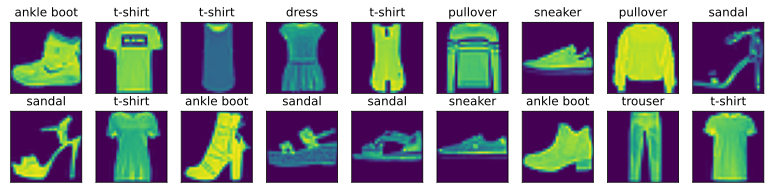

In [59]:
X, y = next(iter(data.DataLoader(mnist_train,batch_size=18))) #下一个样本
show_images(X.reshape(18,28,28),2,9,titles=get_fashion_mnist_labels(y))

In [60]:
batch_size =256

def get_dataloader_workers():
    '''使用4个进程来读取数据'''
    return 4

train_iter = data.DataLoader(
    mnist_train,batch_size,shuffle=True,num_workers=get_dataloader_workers())

timer = d2l.Timer()
for X,y in train_iter:
    continue
f'{timer.stop():.2f} sec'

'3.39 sec'

In [61]:
def load_data_fashion_mnist(batch_size,resize=None):
    '''下载数据然后加载到内存中'''
    trans = [transforms.ToTensor()]
    if resize:
        trans.insert(0,transforms.Resize(resize)) #之后图片可能会更大
    trans = transforms.Compose(trans)
    mnist_train = torchvision.datasets.FashionMNIST(
        root='../data',train=True,transform=trans,download=True
    )
    mnist_test = torchvision.datasets.FashionMNIST(
        root='../data',train=False,transform=trans,download=True
    )
    return (
        data.DataLoader(mnist_train,batch_size,shuffle=True,num_workers=get_dataloader_workers()),
        data.DataLoader(mnist_test,batch_size,shuffle=True,num_workers=get_dataloader_workers())
    )

# 从零开始实现softmax

In [62]:
import torch
from IPython import display
from d2l import torch as d2l

batch_size =256
train_iter,test_iter = d2l.load_data_fashion_mnist(batch_size)

In [146]:
# 初始化参数
num_inputs = 784 #拉长为向量
num_outputs = 10

W = torch.normal(0,0.01,size=(num_inputs,num_outputs),requires_grad=True)
b = torch.zeros(num_outputs,requires_grad=True)

In [ ]:
# X = torch.tensor([[1,2,3],[4,5,6]])
# X.sum(0,keepdim=True) ,X.sum(1,keepdim=True)  # 该维度维数为1

In [132]:
def softmax(X):
    X_exp = torch.exp(X)
    partition = X_exp.sum(1,keepdim=True)
    return X_exp/partition

# 测试
# X = torch.normal(0,1,(2,5))

# X_prob = softmax(X)
# X_prob,X_prob.sum(1)

In [133]:
# 构建模型
def net(X):
    return softmax(torch.matmul(X.reshape((-1,W.shape[0])),W)+b)
    # 固定列数，X实际元素大于input时，多行，利用广播机制将b加到每行上

In [99]:
# y = torch.tensor([0,2]) #两个样本
# y_hat = torch.tensor([[0.1,0.3,0.6],[0.3,0.2,0.5]]) #所有分类对应预测
# y_hat[[0,1],y]  #拿出真实情况对应预测的概率

torch.Size([3])

In [134]:
# 交叉熵
def cross_entropy(y_hat,y):
    return -torch.log(y_hat[range(len(y_hat)),y])  
    #花式索引，拿出真实分类位置对应概率

# cross_entropy(y_hat, y)

In [135]:
def accuracy(y_hat,y):
    if len(y_hat.shape)>1 and y_hat.shape[1]>1: # 矩阵，列有多个分类
        y_hat = y_hat.argmax(axis=1)
    cmp = y_hat.type(y.dtype) == y # y_hat类别转成y的类别并且比较
    return float(cmp.type(y.dtype).sum()) #求和计算个数
# 最后一个batch可能不是batch_size所以应该把所有正确个数相加，然后计算平均
# accuracy(y_hat,y)/len(y)

In [136]:
class Accumulator:
    '''在n个变量上累加'''
    def __init__(self,n):
        self.data = [0.0] * n
    
    def add(self,*args):
        self.data = [a+float(b) for a,b in zip(self.data,args)] 
        # 不断加上传入的参数
    
    def reset(self):
        self.data = [0.0] * len(self.data)
    
    def __getitem__(self,idx):
        return self.data[idx]


In [137]:
def evaluate_accuracy(net,data_iter):
    '''计算制定数据集上模型的精度'''
    if isinstance(net,torch.nn.Module):
        net.eval()                      #  设置成评估模式只forward
    metric = Accumulator(2)  #  传入（正确预测数，预测总数）累加器
    for X,y in data_iter:
        metric.add(accuracy(net(X),y),y.numel())
    return metric[0]/metric[1]

In [138]:
evaluate_accuracy(net,test_iter)  # 准确率

0.1255

In [139]:
def train_epoch_ch3(net,train_iter,loss,updater):
    '''训练函数'''
    if isinstance(net,torch.nn.Module):
        net.train()  
    metric = Accumulator(3)
    for X,y in train_iter:
        y_hat = net(X)
        l = loss(y_hat,y)
        if isinstance(updater,torch.optim.Optimizer):
            updater.zero_grad()
            l.backward()
            updater.step() #参数更新
            metric.add(
                float(1)*len(y),accuracy(y_hat,y),
                y.size().numel()
            )  #标记1 正确数 样本数
        else:
            l.sum().backward()
            updater(X.shape[0]) #batch_size
            metric.add(float(l.sum()),accuracy(y_hat,y),y.numel()) 
            #损失/正确数/样本数
        return metric[0]/metric[2],metric[1]/metric[2] #平均损失，正确率

In [140]:
class Animator:  #@save
    """在动画中绘制数据。"""
    def __init__(self, xlabel=None, ylabel=None, legend=None, xlim=None,
                 ylim=None, xscale='linear', yscale='linear',
                 fmts=('-', 'm--', 'g-.', 'r:'), nrows=1, ncols=1,
                 figsize=(3.5, 2.5)):
        # 增量地绘制多条线
        if legend is None:
            legend = []
        d2l.use_svg_display()
        self.fig, self.axes = d2l.plt.subplots(nrows, ncols, figsize=figsize)
        if nrows * ncols == 1:
            self.axes = [self.axes,]
        # 使用lambda函数捕获参数
        self.config_axes = lambda: d2l.set_axes(self.axes[
            0], xlabel, ylabel, xlim, ylim, xscale, yscale, legend)
        self.X, self.Y, self.fmts = None, None, fmts

    def add(self, x, y):
        # 向图表中添加多个数据点
        if not hasattr(y, "__len__"):
            y = [y]
        n = len(y)
        if not hasattr(x, "__len__"):
            x = [x] * n
        if not self.X:
            self.X = [[] for _ in range(n)]
        if not self.Y:
            self.Y = [[] for _ in range(n)]
        for i, (a, b) in enumerate(zip(x, y)):  #元组列表
            if a is not None and b is not None:
                self.X[i].append(a)
                self.Y[i].append(b)
        self.axes[0].cla()
        for x, y, fmt in zip(self.X, self.Y, self.fmts):
            self.axes[0].plot(x, y, fmt)
        self.config_axes()
        display.display(self.fig)
        display.clear_output(wait=True)

In [141]:
def train_ch3(net,train_iter,test_iter,loss,num_epochs,updater):
    animator = Animator(xlabel='epoch',xlim=[1,num_epochs],ylim=[0.3,0.9],legend=['train loss','train acc','test acc'])
    for epoch in range(num_epochs):
        train_metrics = train_epoch_ch3(net, train_iter, loss, updater)
        test_acc = evaluate_accuracy(net, test_iter)
        animator.add(epoch+1,train_metrics+ (test_acc,))
    train_loss,train_acc = train_metrics
    assert train_loss < 0.5,train_loss    
    assert train_acc <= 1 and train_acc >0.7,train_acc
    assert test_acc <=1 and test_acc>0.7,test-acc

In [144]:
lr = 0.2

def updater(batch_size):
    return d2l.sgd([W,b],lr,batch_size)


AssertionError: 0.69140625

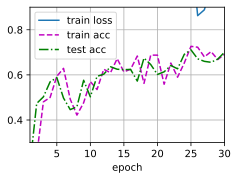

In [147]:
num_epochs = 30
train_ch3(net, train_iter, test_iter, cross_entropy, num_epochs, updater)

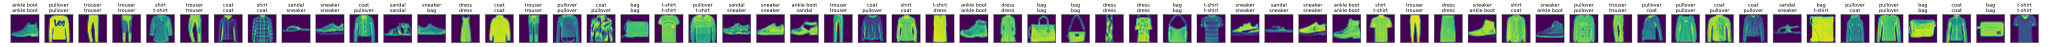

In [148]:
def predict_ch3(net,test_iter,n=60):
    for X,y in test_iter:
        break
    trues = d2l.get_fashion_mnist_labels(y)
    preds = d2l.get_fashion_mnist_labels(net(X).argmax(axis=1))
    titles = [true + '\n' + pred for true,pred in zip(trues,preds)]
    d2l.show_images(X[0:n].reshape((n,28,28)), 1, n,titles=titles[0:n])

predict_ch3(net, test_iter)

In [149]:
import torch
from torch import nn
from d2l import torch as d2l

batch_size = 256
train_iter,test_iter = d2l.load_data_fashion_mnist(batch_size)

In [150]:
net = nn.Sequential(nn.Flatten(),nn.Linear(784,10))
# nn.Flatten用于调整输入的结构
def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.normal_(m.weight,std=0.01) 
        #线性层用正态分布随机值去替换权重

net.apply(init_weights)

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=10, bias=True)
)

In [152]:
# 损失函数
loss = nn.CrossEntropyLoss()

In [151]:
# 优化
trainer = torch.optim.SGD(net.parameters(),lr=0.1)

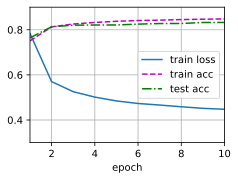

In [153]:
# 训练
num_epochs = 10
d2l.train_ch3(net,train_iter,test_iter,loss,num_epochs,trainer)

# 注意事项
- 0，1 难以拟合，通常用正确的类记作0.9   其余0.1/n
- L1梯度下降均匀 L2速度比较快
- batch_size 影响并行的多少
- 精度一直下降一般是过拟合
- 归一化：处理过拟合
- 本地文件：创建类别文件夹，pytorch可以读入